In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

from keras import models;

In [2]:
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(matrix):
    n = matrix.shape[1]
    cos = lambda a, b: dot(a, b) / (norm(a) * norm(b))
    
    new_matrix = np.zeros([n, n])

    for i in range(n):
        for j in range(i+1):
            new_matrix[i, j] = 1 - cos(matrix[:, i], matrix[:, j])
            new_matrix[j, i] = new_matrix[i, j]

    return new_matrix

def model_cos(model, layer_num):
    layers = model.layers
    weight_matrix = layers[layer_num].get_weights()[0]
    return cosine_similarity(weight_matrix)

In [3]:
from gtda.homology import VietorisRipsPersistence
VR = VietorisRipsPersistence(metric="precomputed")

tries = [480, 240, 120]
cuts = [0, 2, 4]

In [4]:
series_number = 1004242

get_model_directory = lambda series, cut: f"models/{series}_series/{cut}_cut/"
get_model_name = lambda number: f"m_{number}.h5"

def get_model(cut_num, number):
    model_name = get_model_directory(series_number, cut_num) + get_model_name(number)
    return models.load_model(model_name, compile = False) 

In [5]:
def get_model_cos (cut, num):
    model = get_model(cut, num)
    return [model_cos(model, i) for i in range(1, len(model.layers))]

def analyse_model(cut, num):
    return VR.fit_transform(get_model_cos(cut, num)) 

def get_all_diagrams_from(cut, tries_num):
    all = [analyse_model(cut, num) for num in range(1, tries[tries_num]+1)]
    return [[all[i][layer] for i in range(tries[tries_num])] for layer in range(3)] 

In [8]:
list(enumerate([1,2,3]))

[(0, 1), (1, 2), (2, 3)]

In [9]:
def get_diagrams_overall(): 
    return [get_all_diagrams_from(c, i) for (i, c) in enumerate(cuts)]

all_diagrams = get_diagrams_overall()

In [22]:
# import plotly.graph_objects as go
# from gtda.plotting import plot_diagram

# layer = 1

# fig = go.Figure()

# # Add traces, one for each slider step
# dims = [0,1]
# for step in range(tries//4):
#     diagram = all_diagrams[0][layer][step * 4]
#     diagram = diagram[diagram[:, 0] != diagram[:, 1]]
    
#     # fig.add_trace(go.Scatter(
#     # visible = True,
#     # x=[0, 1],
#     # y=[0, 1],
#     # mode="lines",
#     # line={"dash": "dash", "width": 1, "color": "black"},
#     # showlegend=False,
#     # hoverinfo="none"
#     # ))

#     for dim in dims:
#         sub_diagram = diagram[diagram[:, 2] == dim]
        
#         fig.add_trace(
#             go.Scatter(visible = False, x = sub_diagram[:, 0], y = sub_diagram[:, 1], 
#                     mode = "markers", 
#                     name = f"step {4 * (step+1)}, H{dim}")
#         )

# # Create and add slider
# steps = []

# for i in range(0, len(fig.data), 2):
#     step = dict(
#         method="update",
#         args=[{"visible": [False] * len(fig.data)},
#               {"title": "Slider switched to step: " + str(i)}],  # layout attribute
#     )
#     # print(i)
#     step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
#     step["args"][0]["visible"][i+1] = True  # Toggle i'th trace to "visible"
#     steps.append(step)

# sliders = [dict(
#     active=10,
#     currentvalue={"prefix": "Frequency: "},
#     pad={"t": 16},
#     steps=steps
# )]

# fig.update_layout(
#     sliders=sliders, 
#     xaxis = dict(range=[0,1]), 
#     yaxis = dict(range=[0,1]),
#     width = 600, 
#     height = 600
# )

# fig.show()

In [18]:
plt.rcParams["figure.figsize"] = (16,4)

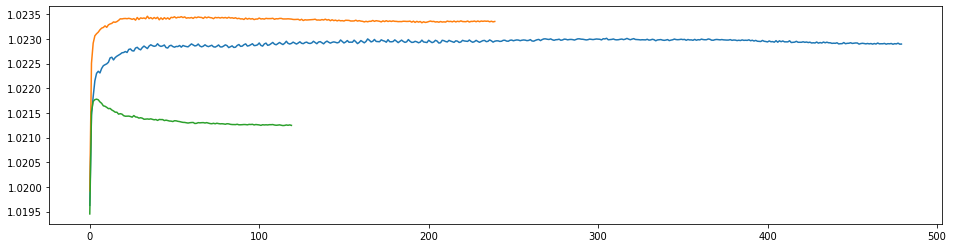

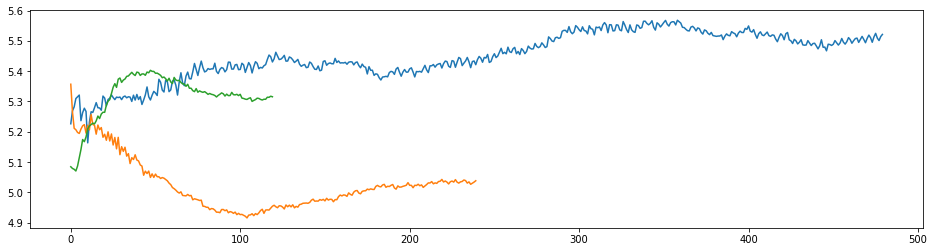

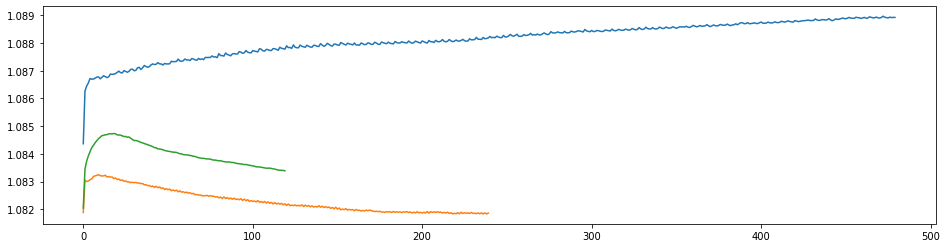

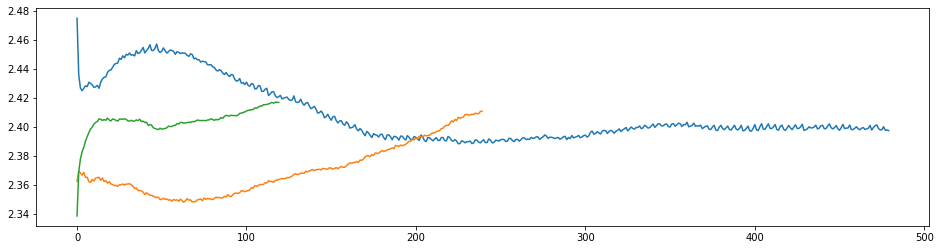

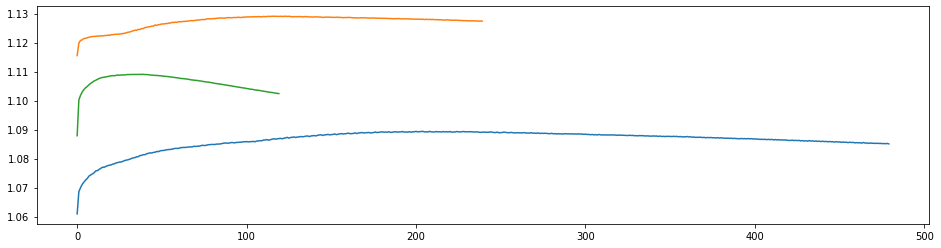

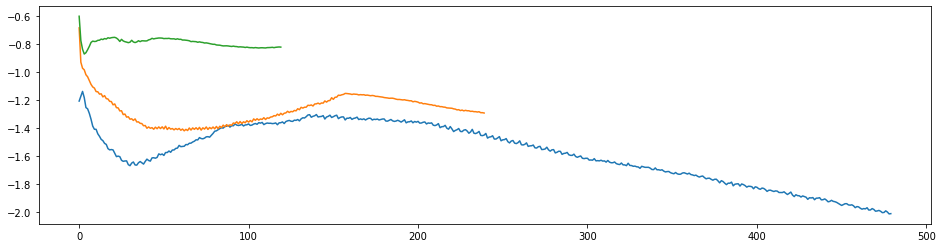

In [19]:
import matplotlib.pyplot as plt
from gtda.diagrams import PersistenceEntropy
persistence = PersistenceEntropy(normalize=True)

entropies = lambda c_i, l, d : np.array([persistence.fit_transform([all_diagrams[c_i][l][i]])[0][d] for i in range(tries[c_i])]) 
c = 0
for l in range(3):
    for d in range(2):
        plt.figure(c)
        c += 1
        for i in range(3):
            plt.plot(list(range(tries[i])), entropies(i, l, d))

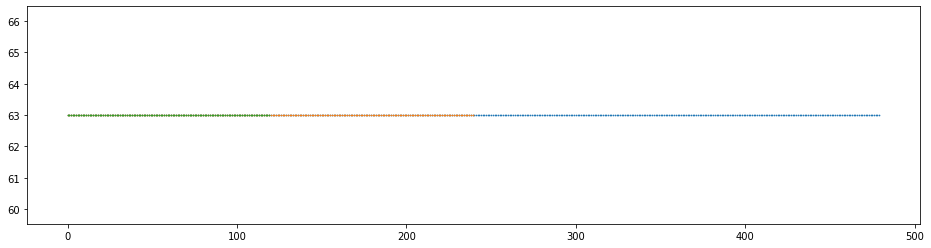

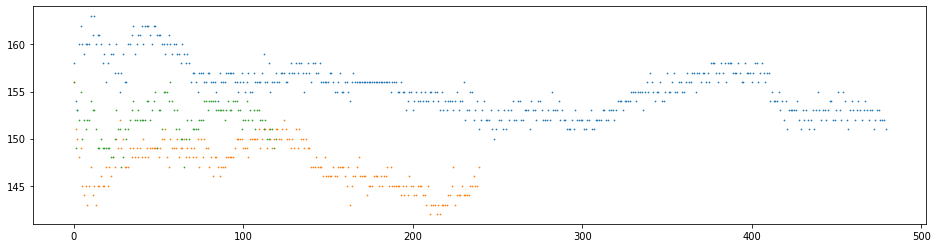

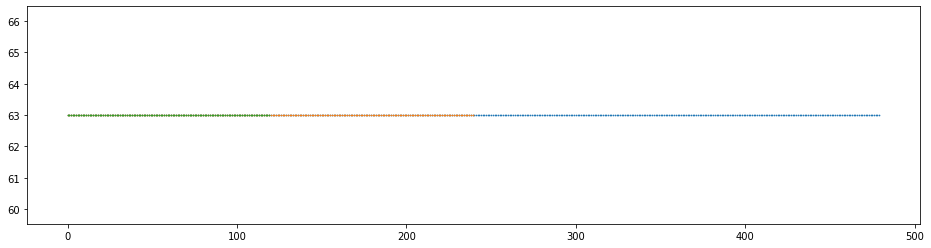

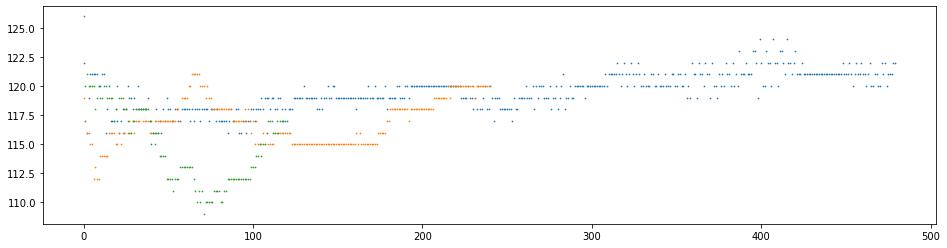

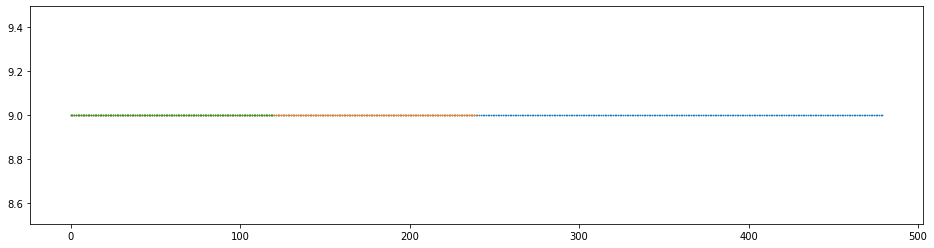

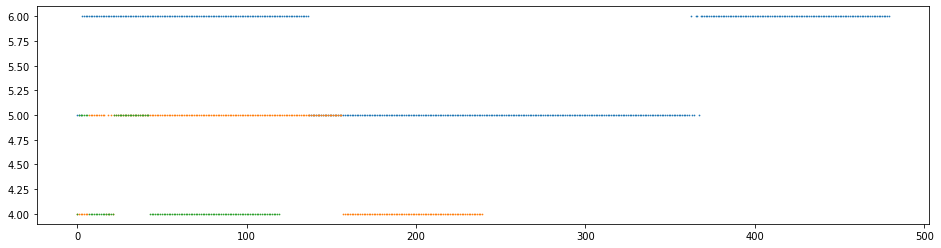

In [21]:
from gtda.diagrams import NumberOfPoints
number_of_points = NumberOfPoints()

number_of_points_func = lambda c_i, l, d : np.array([number_of_points.fit_transform([all_diagrams[c_i][l][i]])[0][d] for i in range(tries[c_i])]) 
c = 0
for l in range(3):
    for d in range(2):
        plt.figure(c)
        c += 1
        for i in range(len(tries)):
            plt.scatter(list(range(tries[i])), number_of_points_func(i, l, d), s = 0.5)

In [23]:
def life_time_(subdiagram):
    return sum([i[1] - i[0] for i in subdiagram])

def left_bound(subdiagram):
    return min(i[0] for i in subdiagram)

def right_bound(subdiagram):
    return max(i[1] for i in subdiagram)

def mean_life_time(diagram, dim):
    subd = diagram[diagram[:, 2] == dim]
    l = life_time_(subd)
    l, r = left_bound(subd), right_bound(subd)
    assert(r > l)

    return l / (r - l)
def life_time(diagram, dim):
    return life_time_(diagram[diagram[:, 2] == dim])

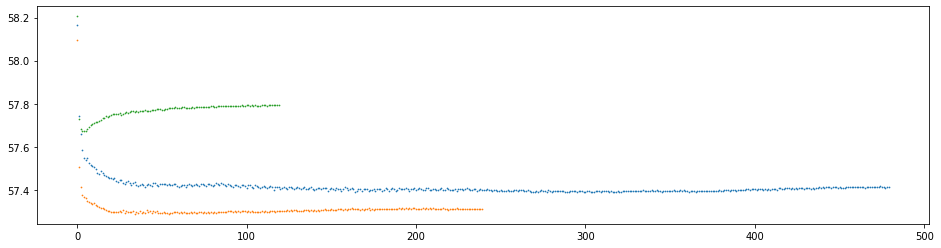

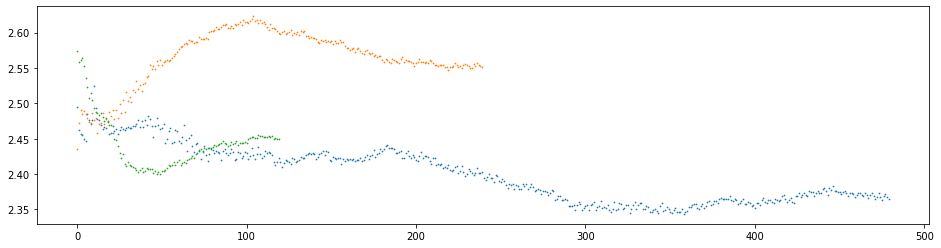

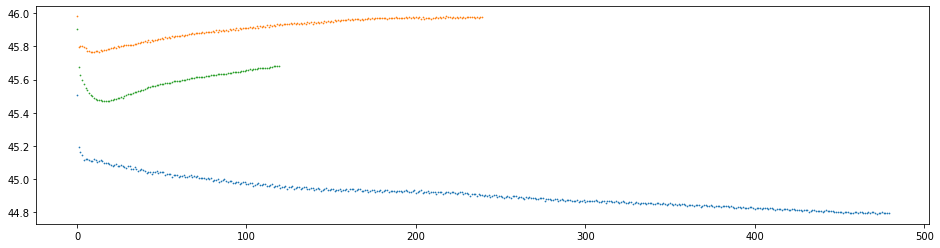

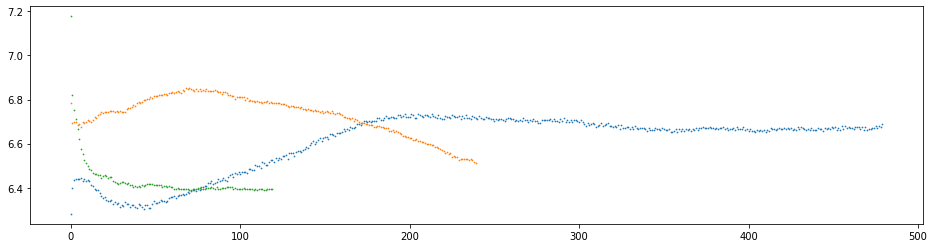

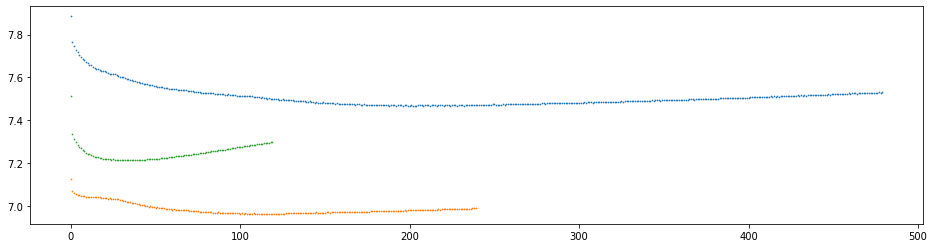

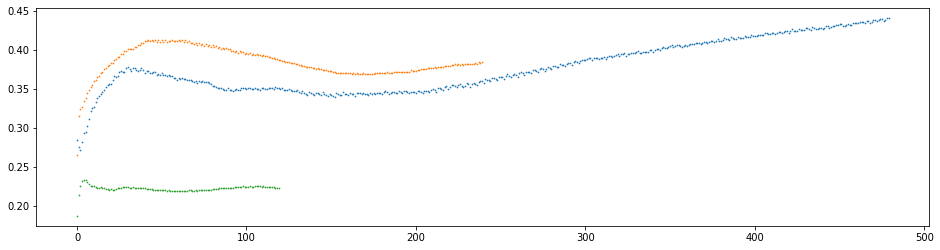

In [24]:
life_time_func = lambda c_i, l, d : np.array([life_time(all_diagrams[c_i][l][i], d) for i in range(tries[c_i])]) 
c = 0
for l in range(3):
    for d in range(2):
        plt.figure(c)
        c += 1
        for i in range(len(tries)):
            plt.scatter(list(range(tries[i])), life_time_func(i, l, d), s = 0.5)

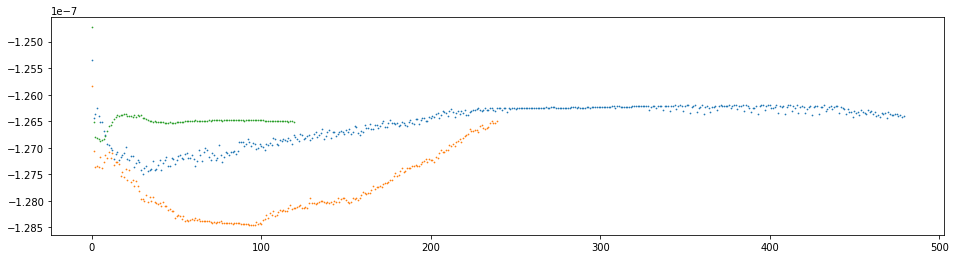

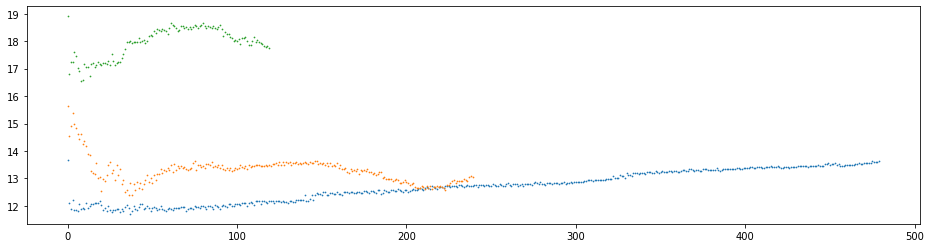

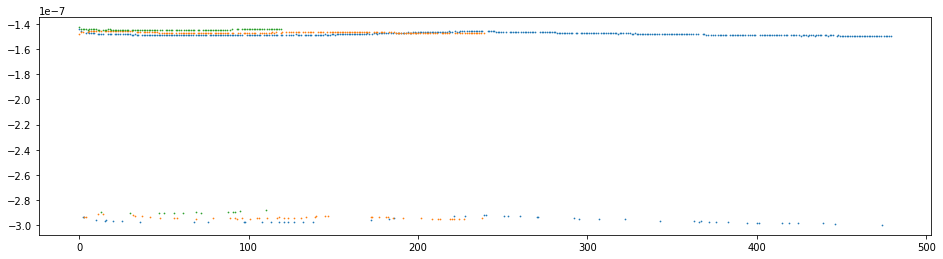

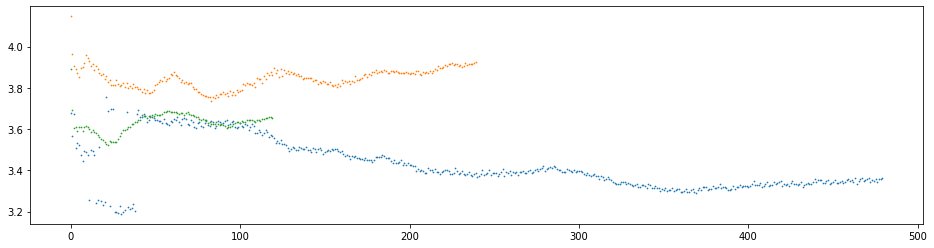

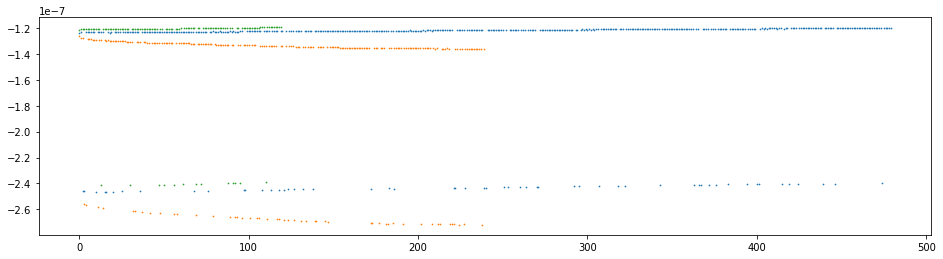

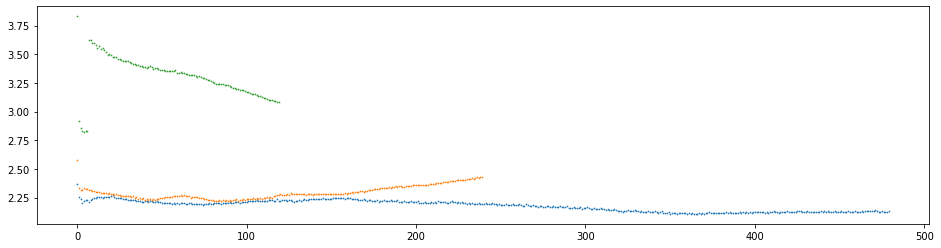

In [25]:
mean_life_time_func = lambda c_i, l, d : np.array([mean_life_time(all_diagrams[c_i][l][i], d) for i in range(tries[c_i])]) 
c = 0
for l in range(3):
    for d in range(2):
        plt.figure(c)
        c += 1
        for i in range(len(tries)):
            plt.scatter(list(range(tries[i])), mean_life_time_func(i, l, d), s = 0.5)

# Урезанные данные

In [106]:
len(all_digrams[0])

240

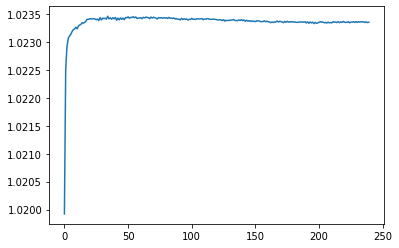

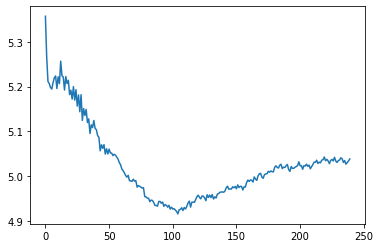

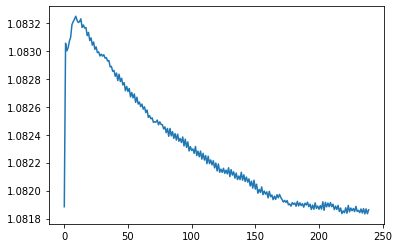

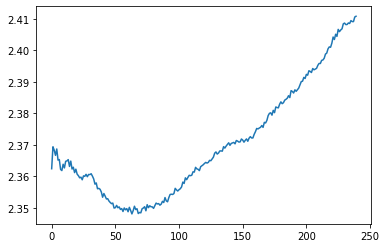

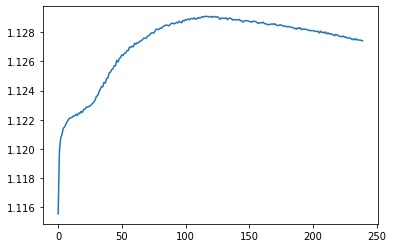

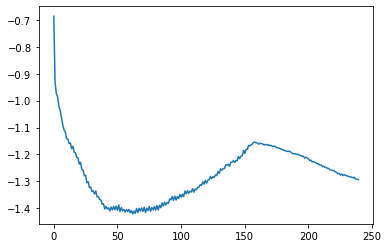

In [107]:
import matplotlib.pyplot as plt
from gtda.diagrams import PersistenceEntropy
persistence = PersistenceEntropy(normalize=True)

cut_num = 0
tries = 240
entropies = lambda l, d : np.array([persistence.fit_transform([all_digrams[l][i]])[0][d] for i in range(tries)]) 

c = 0
for l in range(3):
    for d in range(2):
        plt.figure(c)
        c += 1
        plt.plot(list(range(tries)), entropies(l, d))

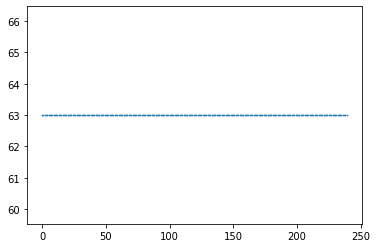

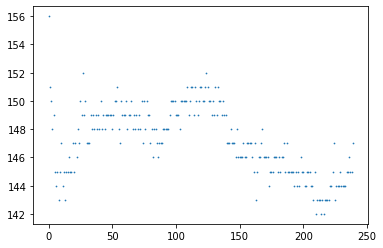

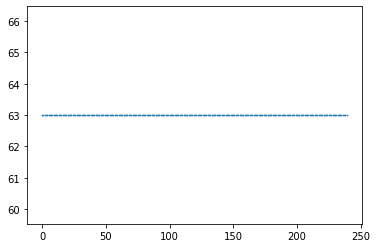

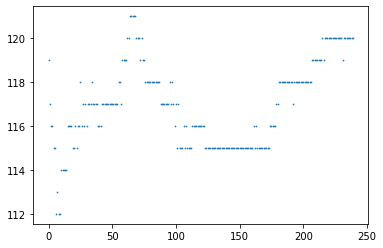

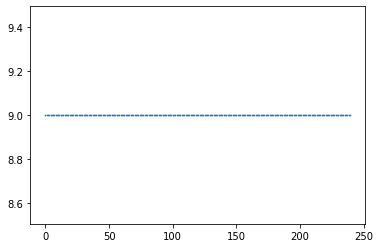

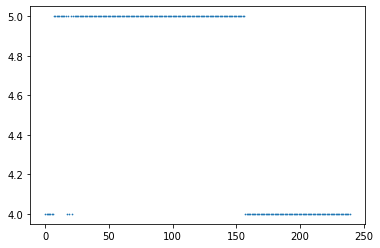

In [108]:
from gtda.diagrams import NumberOfPoints
number_of_points = NumberOfPoints()

number_of_points_func = lambda l, d : np.array([number_of_points.fit_transform([all_digrams[l][i]])[0][d] for i in range(tries)]) 
c = 0
for l in range(3):
    for d in range(2):
        plt.figure(c)
        c += 1
        plt.scatter(list(range(tries)), number_of_points_func(l, d), s = 0.5)

In [111]:
x = all_digrams[0][0]

In [112]:
len(x)

219

In [114]:
x.shape

(219, 3)

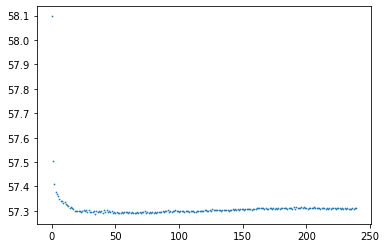

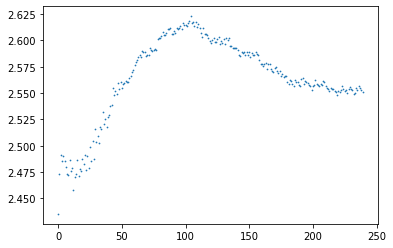

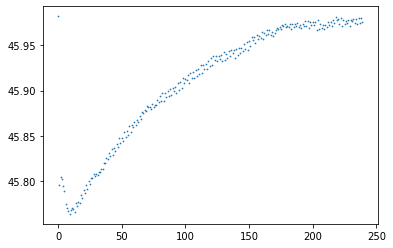

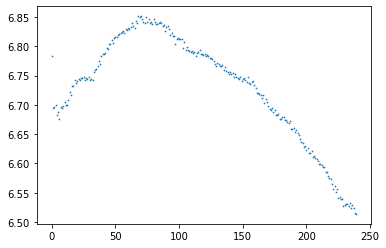

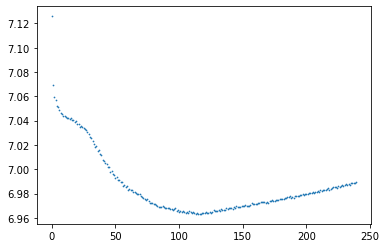

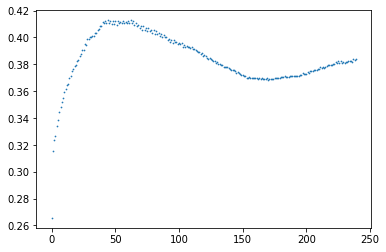

In [117]:
life_time_func = lambda l, d : np.array([life_time(all_digrams[l][i], d) for i in range(tries)]) 
c = 0
for l in range(3):
    for d in range(2):
        plt.figure(c)
        c += 1
        plt.scatter(list(range(tries)), life_time_func(l, d), s = 0.5)

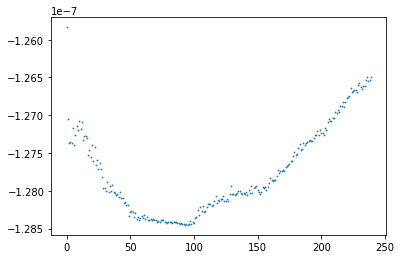

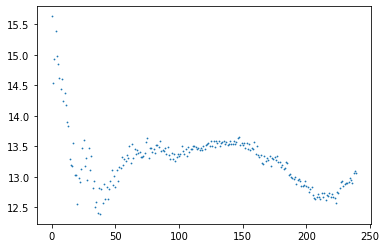

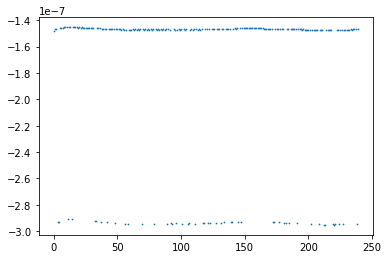

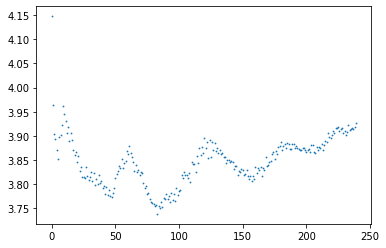

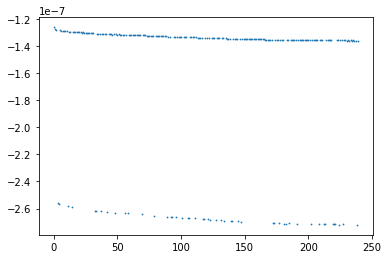

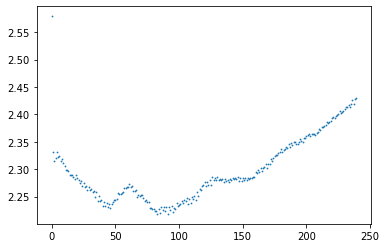

In [119]:
mean_life_time_func = lambda l, d : np.array([mean_life_time(all_digrams[l][i], d) for i in range(tries)]) 
c = 0
for l in range(3):
    for d in range(2):
        plt.figure(c)
        c += 1
        plt.scatter(list(range(tries)), mean_life_time_func(l, d), s = 0.6)